<a href="https://colab.research.google.com/github/meredith224/Pandas_DE_Academy/blob/main/Missing_data_and_interpolation_9_12_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- 1. Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)

# Parameters
n_patients = 30
n_measurements = 10  # ~monthly
dates = pd.date_range("2023-01-01", periods=n_measurements, freq="30D")

# Generate synthetic longitudinal dataset
records = []
for pid in range(1, n_patients + 1):
    weight = np.random.normal(180, 20)   # baseline weight
    bp = np.random.normal(120, 10)       # baseline BP

    for date in dates:
        weight += np.random.normal(-0.5, 1)  # gradual decrease
        bp += np.random.normal(0, 1)         # small variation
        records.append([pid, date, round(weight, 1), round(bp, 1)])

df = pd.DataFrame(records, columns=["PatientID", "Date", "Weight", "BloodPressure"])

# Introduce missingness
df.loc[df.sample(frac=0.05, random_state=42).index, "Weight"] = np.nan
df.loc[df.sample(frac=0.07, random_state=99).index, "BloodPressure"] = np.nan

print(df.head(10))
print(df.tail(10))

   PatientID       Date  Weight  BloodPressure
0          1 2023-01-01   190.1          120.1
1          1 2023-01-31   189.3          119.9
2          1 2023-03-02   190.4            NaN
3          1 2023-04-01   189.5          121.2
4          1 2023-05-01   188.5          120.8
5          1 2023-05-31     NaN          118.8
6          1 2023-06-30   186.0          118.3
7          1 2023-07-30   184.5            NaN
8          1 2023-08-29   183.1          117.2
9          1 2023-09-28     NaN          117.0
     PatientID       Date  Weight  BloodPressure
290         30 2023-01-01   153.4          108.7
291         30 2023-01-31   152.6          107.2
292         30 2023-03-02   151.9          106.9
293         30 2023-04-01   148.7          106.9
294         30 2023-05-01   147.9          107.6
295         30 2023-05-31   149.3          108.7
296         30 2023-06-30   148.5          107.6
297         30 2023-07-30   150.6          107.7
298         30 2023-08-29   150.1         

In [ ]:
# --- 2. Inspect Dataset ---

# Basic structure
print(df.shape)
print(df.info())

# Summary statistics
print(df.describe())

# Missingness
print(df.isna().mean() * 100)  # percentage missing per column


(300, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   PatientID      300 non-null    int64         
 1   Date           300 non-null    datetime64[ns]
 2   Weight         285 non-null    float64       
 3   BloodPressure  279 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 9.5 KB
None
        PatientID                 Date      Weight  BloodPressure
count  300.000000                  300  285.000000     279.000000
mean    15.500000  2023-05-16 00:00:00  177.423860     117.722939
min      1.000000  2023-01-01 00:00:00  137.600000      99.700000
25%      8.000000  2023-03-02 00:00:00  165.400000     110.150000
50%     15.500000  2023-05-16 00:00:00  178.400000     117.800000
75%     23.000000  2023-07-30 00:00:00  186.600000     124.300000
max     30.000000  2023-09-28 00:00:00  226.5

In [ ]:
# --- 2b. Missingness at the Patient Level ---

# Count missing per patient
missing_summary = df.groupby("PatientID").agg(
    MissingWeight=("Weight", lambda x: x.isna().sum()),
    MissingBP=("BloodPressure", lambda x: x.isna().sum()),
    TotalRows=("Weight", "size")
)

# Calculate % missing
missing_summary["PctMissingWeight"] = missing_summary["MissingWeight"] / missing_summary["TotalRows"] * 100
missing_summary["PctMissingBP"] = missing_summary["MissingBP"] / missing_summary["TotalRows"] * 100

missing_summary.head(10)


,MissingWeight,MissingBP,TotalRows,PctMissingWeight,PctMissingBP
PatientID,,,,,
1,2,2,10,20.0,20.0
2,0,2,10,0.0,20.0
3,0,0,10,0.0,0.0
4,0,1,10,0.0,10.0
5,1,2,10,10.0,20.0
6,1,1,10,10.0,10.0
7,0,1,10,0.0,10.0
8,0,0,10,0.0,0.0
9,0,1,10,0.0,10.0


In [ ]:
# Option B: Interpolation within each patient
# → Estimate the missing value by "filling the gap" between known values.
# Example: if a patient had 180 in January and 176 in March,
# the missing February value would be linearly estimated at 178.
df["Weight_interp"] = df.groupby("PatientID")["Weight"].transform(lambda x: x.interpolate())


In [ ]:
# --- 4. Within-Subject Analysis (using interpolated weights) ---

# Change from previous visit (within each patient)
# Using Weight_interp so missing values are smoothed out
df["WeightChange"] = df.groupby("PatientID")["Weight_interp"].diff()
print(df.head(10))
# Summarize per patient
summary = df.groupby("PatientID").agg(
    StartWeight=("Weight_interp", "first"),   # first available (interpolated) weight
    EndWeight=("Weight_interp", "last"),     # last available (interpolated) weight
    TotalChange=("Weight_interp", lambda x: x.iloc[-1] - x.iloc[0])  # net change over time
)

summary.head()


   PatientID       Date  Weight  BloodPressure  Weight_interp  WeightChange
0          1 2023-01-01   190.1          120.1         190.10           NaN
1          1 2023-01-31   189.3          119.9         189.30         -0.80
2          1 2023-03-02   190.4            NaN         190.40          1.10
3          1 2023-04-01   189.5          121.2         189.50         -0.90
4          1 2023-05-01   188.5          120.8         188.50         -1.00
5          1 2023-05-31     NaN          118.8         187.25         -1.25
6          1 2023-06-30   186.0          118.3         186.00         -1.25
7          1 2023-07-30   184.5            NaN         184.50         -1.50
8          1 2023-08-29   183.1          117.2         183.10         -1.40
9          1 2023-09-28     NaN          117.0         183.10          0.00


,StartWeight,EndWeight,TotalChange
PatientID,,,
1,190.1,183.1,-7.0
2,180.3,173.8,-6.5
3,149.5,144.7,-4.8
4,178.4,173.2,-5.2
5,169.0,163.9,-5.1


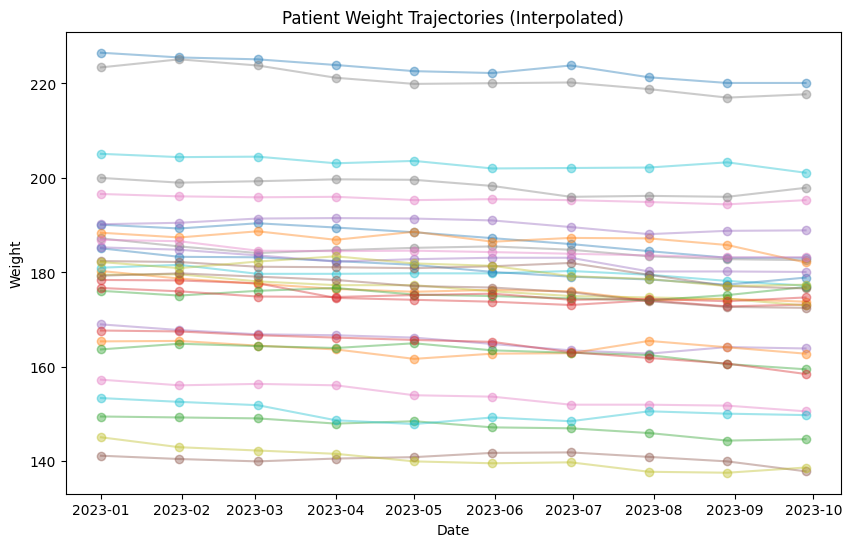

In [ ]:
# --- 6. Visualization (with interpolated weights) ---
# Individual trajectories
plt.figure(figsize=(10,6))
for pid, subdf in df.groupby("PatientID"):
    plt.plot(subdf["Date"], subdf["Weight_interp"], marker="o", alpha=0.4)


plt.title("Patient Weight Trajectories (Interpolated)")
plt.xlabel("Date")
plt.ylabel("Weight")
plt.show()
